In [2]:
"""Analysis framework for checking samples from probability distributions

(1) Features (including proximity value) are calculated
(2) Classifiers are trained (RF)
(3) Permutation feature importance is calculated and fitted with an exponential function.

"""

from numpy import array, linspace, tile, \
                    count_nonzero, zeros, divide, \
                    logical_and, copy, stack

import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier as RF

class Population:
    
    def __init__(self, state, locs, n, mDist=array([])):
        self.N = state.size
        self.state = copy(state)
        self.locs = copy(locs)
        self.n = n
        self.features = dict()
        
        if mDist.shape != (self.N, self.N):
            self.mDist = squareform(pdist(locs))
        else:
            self.mDist = mDist
        
    def density(self):
        int_state = array(self.state, dtype='int32')
        return sum(int_state) * 1.0 / self.N

    def show(self):
        # add figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        
        
        cells = self.locs[self.state == True]
        empty = self.locs[self.state == False]

        ax.scatter(cells[:,0], cells[:,1], color='green', s= 10, alpha=0.5)
        ax.scatter(empty[:,0], empty[:,1], color='red', s=10, alpha=0.5)
        
        return fig, ax
    
    def init_features(self, rmin, rmax, nr):
        """
        Calculate density for given area with radius r.
        
        """
        # init the radii
        self.features = dict()
        radii = linspace(rmin, rmax, num=nr, endpoint=True)
        
        # helper for calculating density gains
        mState = tile(self.state, (self.N, 1))
        previous_density = zeros(self.N)
        
        for radius in radii:
            loc_in_range = self.mDist < radius
            mCells = logical_and(mState, loc_in_range)
        
            n_cells = count_nonzero(mCells, axis=1)
            n_locs = count_nonzero(loc_in_range, axis=1) # symmetric, which axis doesn't matter
            density = divide(n_cells, n_locs)
            
            density_gain = density - previous_density
            
            self.features[radius] = density_gain
            
            previous_density = density
        
    def analyse(self):
        """
        Train Random Forest and compute feature importance.
        """
        
        # prepare data
        data = stack(list(self.features.values()), axis=1)
        targets = self.state
        
        X_train, X_test, y_train, y_test = train_test_split(
            data, targets, random_state=0)
    
        n_est = 100
        model = RF(n_estimators=n_est).fit(X_train, y_train)
    
        # output
        print("Trained Random Forest with n_est=%d." % n_est)
        print("--- Test Sample Size: \t %d" % y_test.size)
        print("--- Train Sample Size: \t %d" % y_train.size)
        print("\n--> Score: \t %.2f" % model.score(X_test, y_test))
    
        # calculate importances
        imp = permutation_importance(
            model, X_test, y_test,
            n_repeats=10, random_state=0, scoring='roc_auc')
        
        
        
        return imp.importances_mean, imp.importances_std
    

Real inital desity n_i = 0.0123

At step 0 -> Population saved with n = 0.012

At step 35 -> Population saved with n = 0.020

At step 63 -> Population saved with n = 0.030

At step 141 -> Population saved with n = 0.091

At step 197 -> Population saved with n = 0.191

At step 267 -> Population saved with n = 0.391

Elapsed time 50.221454


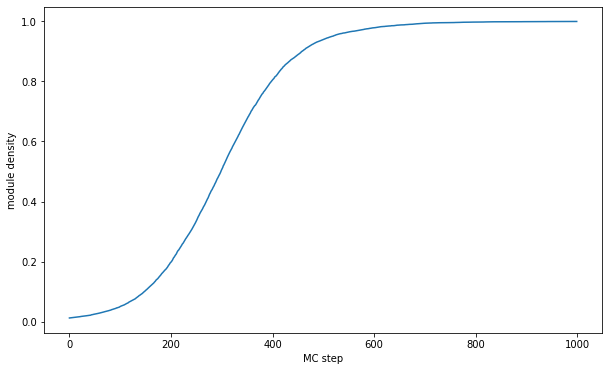

In [5]:
"""Simple Proximity Dynamics Model.

Model the network dynamics of solar panel installation
by assuming panel proximity as the main determining variable.

"""
from time import time

from numpy import array, dot, exp, sqrt
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

# ----------------
# model parameters
# ----------------
# 
# all distances are normalized by r0 = 0.21 km
# i.e. r = 20 corresponds to r_real = 210 m * 20 = 4.2 km
# 
# $ Fresno area (about 270 km^2)
# -> model area 256 km^2 (= 16 x 16 km^2)

r0 = 0.21 # km

# number of addresses
## original number N=3*10^5 
## rescale for computability (limited memory capacity)
NO = 300000
scale = 1.0 / 30
N = int(NO * scale)

# area under test L^2
# rescale by sqrt(scale)
L = 16.0 / r0 * sqrt(scale) # km

# initial panel density
# at start of simulation
# the reference density for the analysis is n=3%
n0 = 0.01

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist*all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]

# save some populations and densities 
# for visualizing and further analysis
densities = []
populations = []

#----------------
# run simulation
#----------------
n_steps = 1000
tStart = time()

tol = 1e-2
ns = [0.02, 0.03, 0.04, 0.1, 0.2, 0.4]

for step in range(n_steps):
    mc_step(locs, state)
    n = density(state)
    densities.append(n)
    
    #if step >= 100 and step < 600 \
    #    and step % 100 == 0:
    for ni in ns:
        if abs(ni - n) < tol:
            ns.pop(0)
            # print information
            print("At step %d -> Population saved with n = %.3f\n" % (step, n))
            populations.append(Population(state, locs, n, mDist=all_dist))

elapsed = time() - tStart
print("Elapsed time %f" % elapsed)
    
fig = plt.figure(figsize=(10, 6))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()


Population analysis n=0.012


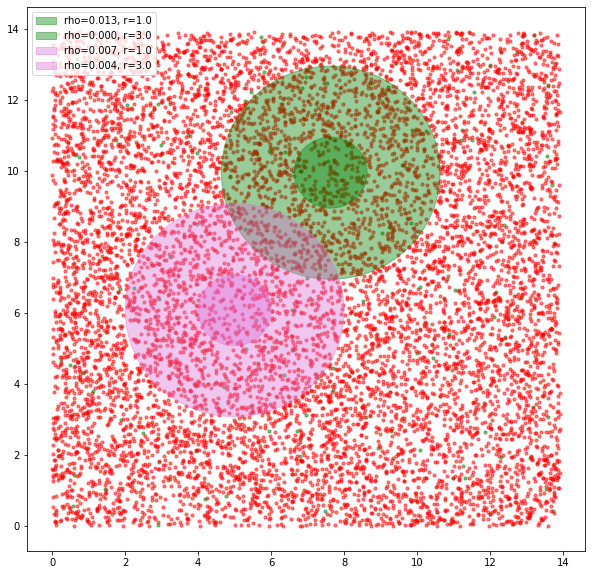

In [8]:
"""
--------------------------------
Analysis of the populations (I)
--------------------------------

Visualization the data and the feature calculation.

"""
import matplotlib.pyplot as plt

# analyse first population
p = populations[0]
print("Population analysis n=%.3f" % p.density())
    
# First, calculate the features
# -> density gain within given radius
rmin = 1.0
rmax = 3.0
nr = 2
p.init_features(rmin, rmax, nr)


# add figure
fig, ax = p.show()

# visualize feature for some indices
# choosed by hand (because of centered location)
indices = [0, 20]
colors = ['green', 'orchid']

circles, labels = [], []
for idx, c in zip(indices, colors):
    
    x, y = p.locs[idx]
    
    for r in linspace(rmin, rmax, nr):
        circle = plt.Circle((x, y), r, color=c, alpha=0.4)
    
        circles.append(circle)
        labels.append('rho=%.3f, r=%.1f' % (p.features[r][idx], r))
    
        ax.add_patch(circle)

ax.legend(circles, labels)

plt.show()


Population analysis n=0.012
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.98
--> r0 = 0.533 +\- 0.397
--> a = 0.349 +\- 0.519


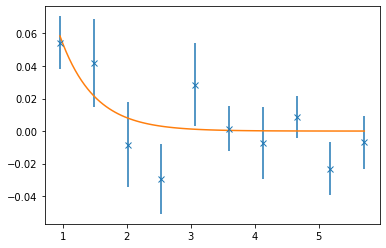


Population analysis n=0.020
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.97
--> r0 = 0.177 +\- 0.893
--> a = 4.031 +\- 109.439


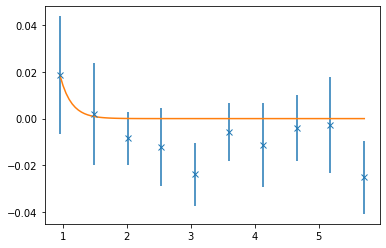


Population analysis n=0.030
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.96
--> r0 = 0.050 +\- 793.194
--> a = -768012.548 +\- 228102923506.986


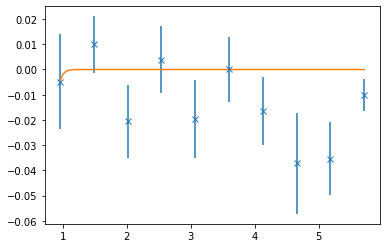


Population analysis n=0.091
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.90
--> r0 = 0.886 +\- 0.436
--> a = 0.124 +\- 0.086


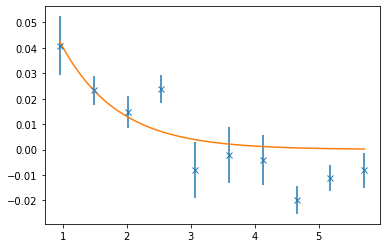


Population analysis n=0.191
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.80
--> r0 = 0.246 +\- 0.121
--> a = 2.877 +\- 5.542


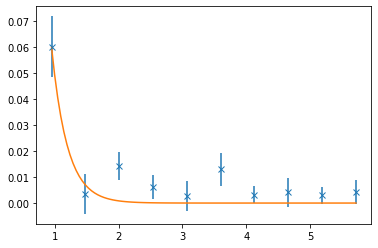


Population analysis n=0.391
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.61
--> r0 = 0.137 +\- 0.167
--> a = 59.410 +\- 503.900


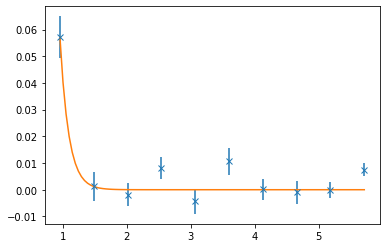

In [10]:
"""
--------------------------------
Analysis of the populations (II)
--------------------------------


"""
import numpy as np

from numpy import exp, inf
from scipy.optimize import minimize, Bounds, curve_fit

import matplotlib.pyplot as plt

# init parameters for feature calculation
rmin = 0.2 / r0
rmax = 1.2 / r0
nr = int((rmax - rmin) * r0 / 0.1) # 0.1 km increaments

def model(x, a, r0):
    return a * np.exp(- x / r0)

def run_analysis(p):
    print("\nPopulation analysis n=%.3f" % p.density())
    p.init_features(rmin, rmax, nr)
    
    mean, std = p.analyse()
    
    # fit exp function to data
    x0 = array([0.0, 0.1])
    bnds = (array([-inf, 0.0]), array([inf, inf]))
    nmax = 5
    popt, pcov = curve_fit(model, array(list(p.features.keys())[:]), mean[:], p0=x0, bounds=bnds)
    
    #result = minimize(chi2, x0, args=(mean[:], array(list(p.features.keys())[:]), std[:]))
    
    # output
    #print("\nSolver terminated successfully with nit=%d" % result.nit)
    perr = np.sqrt(np.diag(pcov))
    print("--> r0 = %.3f +\- %.3f" % (popt[1], perr[1]))
    print("--> a = %.3f +\- %.3f" % (popt[0], perr[0]))
    #print("--> b = %.3f" % result.x[2])
    
    # plot result
    fig = plt.figure()
    plt.errorbar(p.features.keys(), mean, yerr=std, fmt='x')
    
    xs = np.linspace(rmin, rmax, 100)
    plt.plot(xs, model(xs, *popt))
    plt.show()

#################################################
# Population I
# 
for population in populations:
    run_analysis(population)
#run_analysis(populations[1])
#run_analysis(populations[2])
#run_analysis(populations[3])

